# Estimation of effective connectivity using MOU process (MOU-EC)

This Python notebook estimates a matrix of MOU-EC for each fMRI session. The dataset comprises 22 subjects with 5 sessions each (2 for resting-state and 3 for movie, with distinct parts of the movie).

In [1]:
# install the pyMOU library using pip
! pip install git+https://github.com/MatthieuGilson/pyMOU.git@master

  Cloning https://github.com/MatthieuGilson/pyMOU.git (to revision master) to /private/var/folders/kp/r23xdw651klchdzh0p6kj7240000gn/T/pip-req-build-btkuotjg
  Running setup.py bdist_wheel for pyMOU ... done
  Stored in directory: /private/var/folders/kp/r23xdw651klchdzh0p6kj7240000gn/T/pip-ephem-wheel-cache-w7xuxh8v/wheels/fd/ce/66/930772f3e93c5a7f47e74b3c14b9cd52862d2976cfd71de4f8
Successfully built pyMOU
You are using pip version 10.0.1, however version 19.1.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
import os
import numpy as np
import scipy.signal as spsg
from pyMOU.MOU_model import MOU
import matplotlib.pyplot as plt

os.system('clear')

res_dir = 'model_param_movie/'
if not os.path.exists(res_dir):
    print('create directory:',res_dir)
    os.makedirs(res_dir)


create directory: model_param_EC/


## Movie dataset

shape of data array: (22, 5, 66, 300)


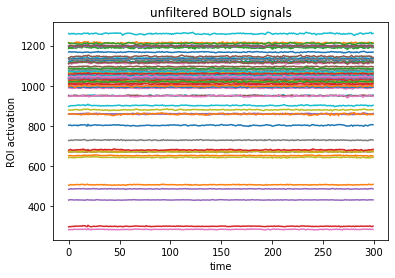

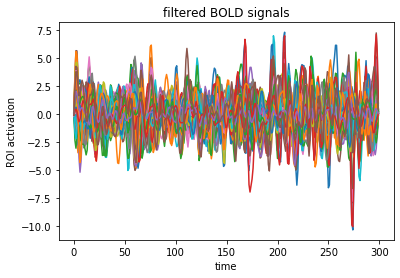

In [8]:
######################
# fMRI data properties    
n_sub = 22 # number of subjects
n_run = 5 # first 2 rest + last 3 movie
N = 66 # number of ROIs
T = 300 # number of TRs of the recording


#################
# functional data
ts_emp = np.load('../../datasets/movie/ts_emp.npy')
print('shape of data array:', ts_emp.shape)

# filtering between 0.01 and 0.1 Hz
n_order = 3
Nyquist_freq = 0.5 / 2. # time resolution (TR) for fMRI = 2 seconds
low_f = 0.01 / Nyquist_freq
high_f = 0.1 / Nyquist_freq
b,a = spsg.iirfilter(n_order,[low_f,high_f],btype='bandpass',ftype='butter')

filtered_ts_emp = spsg.filtfilt(b,a,ts_emp, axis=-1)

# plots
plt.figure()
plt.plot(range(T),ts_emp[0,0,:,:].T)
plt.xlabel('time')
plt.ylabel('ROI activation')
plt.title('unfiltered BOLD signals')

plt.figure()
plt.plot(range(T),filtered_ts_emp[0,0,:,:].T)
plt.xlabel('time')
plt.ylabel('ROI activation')
plt.title('filtered BOLD signals')

plt.show()

In [8]:
# labels for brain regions (ROIs)
ROI_labels = np.load('../../datasets/movie/ROI_labels.npy')
print('original order:\n', ROI_labels)

# reorder ROIs with inverse order for the two hemispheres
new_ind = np.zeros([N],dtype=np.int)
new_ind[:int(N/2)] = np.arange(int(N/2))
new_ind[int(N/2):] = N - 1 - np.arange(int(N/2))
#print(new_ind)

ROI_labels = ROI_labels[new_ind]
filtered_ts_emp = filtered_ts_emp[:,:,new_ind,:]
print('new order:\n', ROI_labels)



original order:
 ['rBSTS' ' rCAC' ' rCMF' ' rCUN' ' rENT' '  rFP' ' rFUS' '  rIP' '  rIT'
 'rISTC' 'rLOCC' ' rLOF' 'rLING' ' rMOF' '  rMT' 'rPARC' 'rPARH' 'rPOPE'
 'rPORB' 'rPTRI' 'rPCAL' 'rPSTC' '  rPC' 'rPREC' 'rPCUN' ' rRAC' ' rRMF'
 '  rSF' '  rSP' '  rST' 'rSMAR' '  rTP' '  rTT' 'lBSTS' ' lCAC' ' lCMF'
 ' lCUN' ' lENT' '  lFP' ' lFUS' '  lIP' '  lIT' 'lISTC' 'lLOCC' ' lLOF'
 'lLING' ' lMOF' '  lMT' 'lPARC' 'lPARH' 'lPOPE' 'lPORB' 'lPTRI' 'lPCAL'
 'lPSTC' '  lPC' 'lPREC' 'lPCUN' ' lRAC' ' lRMF' '  lSF' '  lSP' '  lST'
 'lSMAR' '  lTP' '  lTT']
new order:
 ['rBSTS' ' rCAC' ' rCMF' ' rCUN' ' rENT' '  rFP' ' rFUS' '  rIP' '  rIT'
 'rISTC' 'rLOCC' ' rLOF' 'rLING' ' rMOF' '  rMT' 'rPARC' 'rPARH' 'rPOPE'
 'rPORB' 'rPTRI' 'rPCAL' 'rPSTC' '  rPC' 'rPREC' 'rPCUN' ' rRAC' ' rRMF'
 '  rSF' '  rSP' '  rST' 'rSMAR' '  rTP' '  rTT' '  lTT' '  lTP' 'lSMAR'
 '  lST' '  lSP' '  lSF' ' lRMF' ' lRAC' 'lPCUN' 'lPREC' '  lPC' 'lPSTC'
 'lPCAL' 'lPTRI' 'lPORB' 'lPOPE' 'lPARH' 'lPARC' '  lMT' ' lMOF' 'lLI

## Functional connectivity

max FC value (most of the distribution should be between 0 and 1): 3.2977812262243993


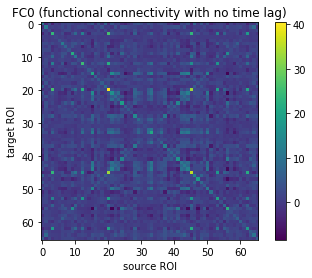

In [9]:
# time shifts for FC: 0, 1 and 2 TR
v_tau = np.arange(3,dtype=float)
n_tau = v_tau.size

FC_emp = np.zeros([n_sub,n_run,n_tau,N,N]) # FC = spatiotemporal covariances of BOLD signals
for i_sub in range(n_sub):
    for i_run in range(n_run):
        # center the time series
        filtered_ts_emp[i_sub,i_run,:,:] -= np.outer(filtered_ts_emp[i_sub,i_run,:,:].mean(1),np.ones([T]))
        # calculate covariances with time shift
        for i_tau in range(n_tau):
            FC_emp[i_sub,i_run,i_tau,:,:] = np.tensordot(filtered_ts_emp[i_sub,i_run,:,0:T-n_tau+1],filtered_ts_emp[i_sub,i_run,:,i_tau:T-n_tau+1+i_tau],axes=(1,1)) / float((T-n_tau))

rescale_FC_factor = 0.5 / FC_emp[:,:2,0,:,:].diagonal(axis1=2,axis2=3).mean()
FC_emp /= rescale_FC_factor
filtered_ts_emp /= np.sqrt(rescale_FC_factor)

print('max FC value (most of the distribution should be between 0 and 1):',FC_emp.mean())

# show FC0 for first subject, first run (rest)
plt.imshow(FC_emp[0,0,0,:,:])
plt.colorbar()
plt.xlabel('source ROI')
plt.ylabel('target ROI')
plt.title('FC0 (functional connectivity with no time lag)')

plt.show()

## Structural connectivity for movie data

EC density: 0.27505827505827507


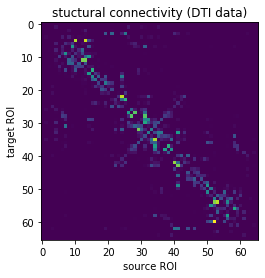

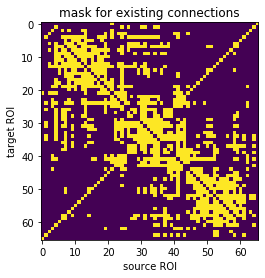

In [10]:
SC_anat = np.load('../../datasets/movie/SC_anat.npy')

lim_SC = 0. # limit DTI value to determine SC (only connections with larger values are tuned)

# mask for existing connections for EC
mask_EC = np.zeros([N,N],dtype=bool) # EC weights to tune
mask_EC[SC_anat>lim_SC] = True
for i in range(N):
    mask_EC[i,i] = False # no self connection
    mask_EC[i,N-1-i] = True # additional interhemispheric connections
print('EC density:',mask_EC.sum()/float(N*(N-1)))

# diagonal mask for input noise matrix (here, no input cross-correlation)
mask_Sigma = np.eye(N,dtype=bool)

# plots
plt.figure()
plt.imshow(SC_anat)
plt.xlabel('source ROI')
plt.ylabel('target ROI')
plt.title('stuctural connectivity (DTI data)')

plt.figure()
plt.imshow(mask_EC)
plt.xlabel('source ROI')
plt.ylabel('target ROI')
plt.title('mask for existing connections')

plt.show()

## MOU-EC estimation

In [11]:
####################
# model optimization
J_mod = np.zeros([n_sub,n_run,N,N]) # Jacobian (off-diagonal elements = EC)
Sigma_mod = np.zeros([n_sub,n_run,N,N]) # local variance
dist_mod = np.zeros([n_sub,n_run]) # model error
R2_mod = np.zeros([n_sub,n_run]) # model error

mou_model = MOU()

for i_sub in range(n_sub):
    for i_run in range(n_run):
        print('sub',i_sub,'; run',i_run)

        # estimate model parameters for each session
        mou_model.fit(filtered_ts_emp[i_sub,i_run,:,:].T,mask_C=mask_EC,mask_Sigma=mask_Sigma)

        J_mod[i_sub,i_run,:,:] = mou_model.J
        Sigma_mod[i_sub,i_run,:,:] = mou_model.Sigma
        dist_mod[i_sub,i_run] = mou_model.d_fit['distance']
        R2_mod[i_sub,i_run] = mou_model.d_fit['correlation']**2

# save results
np.save(res_dir+'FC_emp.npy',FC_emp) # empirical spatiotemporal FC
np.save(res_dir+'mask_EC.npy',mask_EC) # mask of optimized connections
np.save(res_dir+'mask_Sigma.npy',mask_Sigma) # mask of optimized Sigma elements

np.save(res_dir+'J_mod.npy',J_mod) # estimated Jacobian matrices (EC + inverse time constant on diagonal)
np.save(res_dir+'Sigma_mod.npy',Sigma_mod) # estimated Sigma matrices
np.save(res_dir+'dist_mod.npy',dist_mod) # model error

sub 0 ; run 0
sub 0 ; run 1
sub 0 ; run 2
sub 0 ; run 3
sub 0 ; run 4
sub 1 ; run 0
sub 1 ; run 1
sub 1 ; run 2
sub 1 ; run 3
sub 1 ; run 4
sub 2 ; run 0
sub 2 ; run 1
sub 2 ; run 2
sub 2 ; run 3
sub 2 ; run 4
sub 3 ; run 0
sub 3 ; run 1
sub 3 ; run 2
sub 3 ; run 3
sub 3 ; run 4
sub 4 ; run 0
sub 4 ; run 1
sub 4 ; run 2
sub 4 ; run 3
sub 4 ; run 4
sub 5 ; run 0
sub 5 ; run 1
sub 5 ; run 2
sub 5 ; run 3
sub 5 ; run 4
sub 6 ; run 0
sub 6 ; run 1
sub 6 ; run 2
sub 6 ; run 3
sub 6 ; run 4
sub 7 ; run 0
sub 7 ; run 1
sub 7 ; run 2
sub 7 ; run 3
sub 7 ; run 4
sub 8 ; run 0
sub 8 ; run 1
sub 8 ; run 2
sub 8 ; run 3
sub 8 ; run 4
sub 9 ; run 0
sub 9 ; run 1
sub 9 ; run 2
sub 9 ; run 3
sub 9 ; run 4
sub 10 ; run 0
sub 10 ; run 1
sub 10 ; run 2
sub 10 ; run 3
sub 10 ; run 4
sub 11 ; run 0
sub 11 ; run 1
sub 11 ; run 2
sub 11 ; run 3
sub 11 ; run 4
sub 12 ; run 0
sub 12 ; run 1
sub 12 ; run 2
sub 12 ; run 3
sub 12 ; run 4
sub 13 ; run 0
sub 13 ; run 1
sub 13 ; run 2
sub 13 ; run 3
sub 13 ; run 4


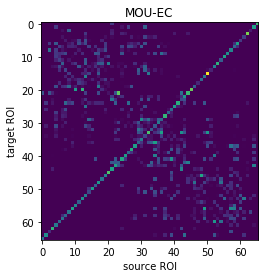

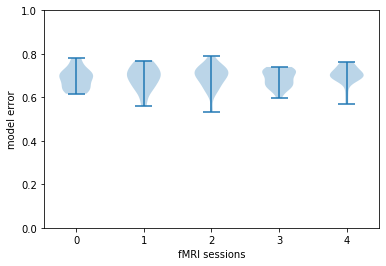

In [12]:
# display an exmaple MOU-EC matrix and the model error for all runs and subjects
plt.figure()
plt.imshow(np.maximum(J_mod[0,0,:,:],0))
plt.xlabel('source ROI')
plt.ylabel('target ROI')
plt.title('MOU-EC')

plt.figure()
plt.violinplot(dist_mod,positions=range(n_run))
plt.axis(ymin=0,ymax=1)
plt.xlabel('fMRI sessions')
plt.ylabel('model error')

plt.show()

## Exercises

- Compare EC between rest and movie, for example using statistical testing (Welch t-test).
- Compare graph metrics on EC (as a directed weighted matrix) to corresponding graph metrics on SC, for example the node strength/degree to see how their hierarchy may differ (in particular between the two conditions, rest and movie).
- Compare EC with partial correlations PC.

## Extra code to apply to the 2nd dataset (resting-state + structural for 20 subjects)

See folder 'datasets/resting/Human/'

In [34]:
#########E#########
# global properties    
n_sub = 20 # number of subjects
N = 68 # number of ROIs
T = 242 # number of TRs of the recording

res_dir = 'model_param_ARCHI/'

#################
# functional data
ts_emp = np.load('../../datasets/resting/Human/BOLD_20subs_Detrended.npy')
print('shape of fMRI data array:', ts_emp.shape)

# filtering between 0.01 and 0.1 Hz
n_order = 3
Nyquist_freq = 0.5 / 2.4
low_f = 0.01 / Nyquist_freq
high_f = 0.1 / Nyquist_freq
b,a = spsg.iirfilter(n_order,[low_f,high_f],btype='bandpass',ftype='butter')

filtered_ts_emp = spsg.filtfilt(b,a,ts_emp, axis=-1)


#################
# structural data

mask_EC = np.array(np.load('../../datasets/resting/Human/SCnet_AverageBinary.npy'), dtype=np.bool) # already binarized
print('EC density:',mask_EC.sum()/float(N*(N-1)))

# diagonal mask for input noise matrix (here, no input cross-correlation)
mask_Sigma = np.eye(N,dtype=bool)


####################
# model optimization
J_mod = np.zeros([n_sub,N,N]) # Jacobian (off-diagonal elements = EC)
Sigma_mod = np.zeros([n_sub,N,N]) # local variance
dist_mod = np.zeros([n_sub]) # model error

mou_model = MOU()

for i_sub in range(n_sub):
    print('sub',i_sub)

    # estimate model parameters for each session
    mou_model.fit(filtered_ts_emp[i_sub,:,:].T,mask_C=mask_EC,mask_Sigma=mask_Sigma)

    J_mod[i_sub,:,:] = mou_model.J
    Sigma_mod[i_sub,:,:] = mou_model.Sigma
    dist_mod[i_sub] = mou_model.d_fit['distance']

# save results
np.save(res_dir+'mask_EC.npy',mask_EC) # mask of optimized connections
np.save(res_dir+'mask_Sigma.npy',mask_Sigma) # mask of optimized Sigma elements

np.save(res_dir+'J_mod.npy',J_mod) # estimated Jacobian matrices (EC + inverse time constant on diagonal)
np.save(res_dir+'Sigma_mod.npy',Sigma_mod) # estimated Sigma matrices

shape of data array: (20, 68, 242)
EC density: 0.2497805092186128
sub 0
sub 1
sub 2
sub 3
sub 4
sub 5
sub 6
sub 7
sub 8
sub 9
sub 10
sub 11
sub 12
sub 13
sub 14
sub 15
sub 16
sub 17
sub 18
sub 19
